In [126]:
import itertools
from functools import partial
from math import erf as erf_, exp as exp_, sin
from typing import Optional
from timeit import default_timer
import torchvision

import math
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import numpy.typing as npt
import numba.types as nbt
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.optim import Adam, AdamW, SGD
from numpy import pi, sqrt
from sklearn.model_selection import train_test_split
from torch.nn.parameter import Parameter
from tqdm import tqdm
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [162]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cdouble))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cdouble))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cdouble, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic

        self.p = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        #x = nn.BatchNorm2d(self.width)(x)
        x = F.gelu(x)
        x = nn.Dropout(p=0.1)(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        #x = nn.BatchNorm2d(self.width)(x)
        x = F.gelu(x)
        x = nn.Dropout(p=0.1)(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        #x = nn.BatchNorm2d(self.width)(x)
        x = F.gelu(x)
        x = nn.Dropout(p=0.1)(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [94]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [95]:
@nb.njit('f8[:,::1](f8[:,::1], f8)')
def solve_heat_eqn(A0, t_fin: float = 1.):
    m, n = A0.shape
    Anext = np.copy(A0)
    A = np.copy(Anext)
    ht = 0.001
    hx = 0.002
    kc = 0.0006
    r = (ht * kc) / hx**2

    t = 0.
    while t < t_fin:
        for j in range(1, n-1):
            for i in range(1, m-1):
                Anext[i, j] = (A[i, j]
                               + r*(A[i, j+1]
                                    + A[i+1, j]
                                    + A[i, j-1]
                                    + A[i-1, j]
                                    - 4.*A[i, j]))
        A = np.copy(Anext)
        t += min(ht, t_fin-t)

    return A


class SkoltechPicsDataset(Dataset):
    """Skoltech pic dataset"""

    def __init__(self, root_dir: str, transform=None):
        """
        Args:
            root_dir: Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img = np.array(Image.open('/kaggle/input/pictures-2d-fno/train/' + img_name).convert('L'))
        img = img.astype(np.float64)

        if self.transform is not None:
            img = self.transform(img)

        return (img, solve_heat_eqn(img, 0.1))

In [96]:
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

        
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [124]:
def train(epochs, myloss, optimizer, scheduler):
    
    train_l2_ch = []
    test_l2_ch = []
    #animation = []
    y_normalizer.cuda()
    
    for ep in tqdm(range(epochs)):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x).reshape(batch_size, int(500/s), int(500/s))
            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)

            loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()
            
        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x).reshape(batch_size, int(500/s), int(500/s))
                out = y_normalizer.decode(out)

                test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

        train_l2/= n_cut_train
        test_l2 /= n_cut_test
        train_l2_ch.append(train_l2)
        test_l2_ch.append(test_l2)
        
        """
        x_ani = torch.from_numpy(real_panic_initial[::10,::10])
        x_ani = x_ani.reshape(1, *x_ani.shape, 1)
        y_ani = model(x_ani.cuda()).detach().cpu().numpy()
        animation.append(y_ani.reshape(int(500/s), int(500/s)))
        """

        t2 = default_timer()
        print(ep, t2-t1, train_l2, test_l2)
    return train_l2_ch, test_l2_ch

In [100]:
data = SkoltechPicsDataset('/kaggle/input/pictures-2d-fno/train')

In [ ]:
class SkoltechPicsDataset(Dataset):
    """Skoltech pic dataset"""

    def __init__(self, root_dir: str, transform=None):
        """
        Args:
            root_dir: Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img = np.array(Image.open(self.root_dir + '\\' + img_name).convert('L'))
        img = img.astype(np.float64)

        if self.transform is not None:
            img = self.transform(img)

        return (img, solve_heat_eqn(img, 0.1))
    
panic = data = SkoltechPicsDataset('/kaggle/input/panic')
real_panic = panic[0]
real_panic_initial, real_panic_diff = real_panic

In [122]:
slash = '\\'
chr(92) + 'img'

'\\img'

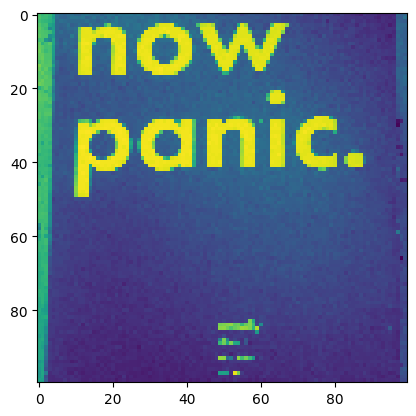

In [55]:
plt.imshow(real_panic_initial[::10, ::10])

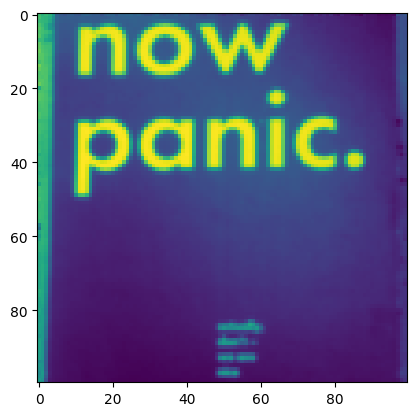

In [54]:
plt.imshow(real_panic_diff[::10, ::10])

In [101]:
ntrain = 1200
ntest = 400

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64

s = 10

x_full_train = []
y_full_train = []
x_full_test = []
y_full_test = []

for i in tqdm(range(ntrain)):
    x_train, y_train = data[i]
    x_full_train.append(x_train)
    y_full_train.append(y_train)
    
for i in tqdm(range(ntrain, ntrain + ntest)):
    x_test, y_test = data[i]
    x_full_test.append(x_test)
    y_full_test.append(y_test)

x_full_train = np.array(x_full_train)
y_full_train = np.array(y_full_train)
x_full_test = np.array(x_full_test)
y_full_test = np.array(y_full_test)

100%|██████████| 400/400 [00:41<00:00,  9.72it/s]


In [169]:
s = 5
n_cut_train = 1200
n_cut_test = 400

x_train_cut = x_full_train[:n_cut_train, ::s,::s]
x_test_cut = x_full_test[:n_cut_test, ::s, ::s]

y_train_cut = y_full_train[:n_cut_train, ::s,::s]
y_test_cut = y_full_test[:n_cut_test, ::s, ::s]

y_train_cut = torch.from_numpy(y_train_cut)
x_train_cut = torch.from_numpy(x_train_cut)
y_test_cut = torch.from_numpy(y_test_cut).to(device)
x_test_cut = torch.from_numpy(x_test_cut)

x_normalizer = UnitGaussianNormalizer(x_train_cut)
y_normalizer = UnitGaussianNormalizer(y_train_cut)

x_train_cut = x_normalizer.encode(x_train_cut)
x_test_cut = x_normalizer.encode(x_test_cut)
y_train_cut = y_normalizer.encode(y_train_cut).to(device)

x_train_cut = x_train_cut.reshape(n_cut_train, int(500/s), int(500/s), 1).to(device)
x_test_cut = x_test_cut.reshape(n_cut_test, int(500/s), int(500/s), 1).to(device)

#y_train_cut = y_train_cut.reshape(ntrain, int(500/s), int(500/s), 1)
#y_test_cut = y_test_cut.reshape(ntest, int(500/s), int(500/s), 1)

In [170]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_cut, y_train_cut), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_cut, y_test_cut), batch_size=batch_size, shuffle=False, drop_last=True)

In [171]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f'{name}: {params}')
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params

modes = 12
width = 32

model = FNO2d(modes, modes, width).double().to(device)

print(count_parameters(model))

p.weight: 96
p.bias: 32
conv0.weights1: 147456
conv0.weights2: 147456
conv1.weights1: 147456
conv1.weights2: 147456
conv2.weights1: 147456
conv2.weights2: 147456
conv3.weights1: 147456
conv3.weights2: 147456
mlp0.mlp1.weight: 1024
mlp0.mlp1.bias: 32
mlp0.mlp2.weight: 1024
mlp0.mlp2.bias: 32
mlp1.mlp1.weight: 1024
mlp1.mlp1.bias: 32
mlp1.mlp2.weight: 1024
mlp1.mlp2.bias: 32
mlp2.mlp1.weight: 1024
mlp2.mlp1.bias: 32
mlp2.mlp2.weight: 1024
mlp2.mlp2.bias: 32
mlp3.mlp1.weight: 1024
mlp3.mlp1.bias: 32
mlp3.mlp2.weight: 1024
mlp3.mlp2.bias: 32
w0.weight: 1024
w0.bias: 32
w1.weight: 1024
w1.bias: 32
w2.weight: 1024
w2.bias: 32
w3.weight: 1024
w3.bias: 32
q.mlp1.weight: 4096
q.mlp1.bias: 128
q.mlp2.weight: 128
q.mlp2.bias: 1
Total Trainable Params: 1196801
1196801


In [172]:
learning_rate = 7e-3
step_size = 50
gamma = 0.5
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
                                                       
loss = LpLoss(size_average=False)

In [173]:
train_l2_ch, test_l2_ch = train(50, loss, optimizer, scheduler)

  2%|▏         | 1/50 [00:08<07:10,  8.78s/it]

0 8.777812753000035 0.0985249954107403 0.06842322999522787


  4%|▍         | 2/50 [00:17<07:00,  8.77s/it]

1 8.758669708000525 0.064843180331094 0.06404430329797037


  6%|▌         | 3/50 [00:26<06:52,  8.77s/it]

2 8.767622839000978 0.062391120143255895 0.06461325219642515


  8%|▊         | 4/50 [00:35<06:43,  8.77s/it]

3 8.759048634001374 0.06135039402693985 0.06235669636367109


 10%|█         | 5/50 [00:43<06:34,  8.77s/it]

4 8.77267911600029 0.05879999401930669 0.0582076969477273


 12%|█▏        | 6/50 [00:52<06:25,  8.77s/it]

5 8.757842402999813 0.056773853732978136 0.057397611784110486


 14%|█▍        | 7/50 [01:01<06:16,  8.76s/it]

6 8.762294301999646 0.05639512020064703 0.056068828758904295


 16%|█▌        | 8/50 [01:10<06:08,  8.77s/it]

7 8.767395890001353 0.05510485761798885 0.056284286285161605


 18%|█▊        | 9/50 [01:18<05:59,  8.77s/it]

8 8.764251894999688 0.053157767563024726 0.056248057847882976


 20%|██        | 10/50 [01:27<05:50,  8.77s/it]

9 8.762854307000453 0.05265106965488146 0.05353443069492472


 22%|██▏       | 11/50 [01:36<05:41,  8.76s/it]

10 8.761045708999518 0.051430295725671676 0.0579852258677573


 24%|██▍       | 12/50 [01:45<05:33,  8.76s/it]

11 8.763054218999969 0.050460364154681296 0.05230995687039504


 26%|██▌       | 13/50 [01:53<05:24,  8.76s/it]

12 8.76259691300038 0.04888341991386196 0.05041130825518943


 28%|██▊       | 14/50 [02:02<05:15,  8.76s/it]

13 8.762816878999729 0.0483168459630699 0.050661395611142315


 30%|███       | 15/50 [02:11<05:06,  8.76s/it]

14 8.761704000999089 0.04733228876286294 0.05325628954791699


 32%|███▏      | 16/50 [02:20<04:58,  8.76s/it]

15 8.765191497999695 0.04634655433335139 0.048767826480983344


 34%|███▍      | 17/50 [02:29<04:49,  8.76s/it]

16 8.7561819069997 0.046333472795973975 0.04894243365585799


 36%|███▌      | 18/50 [02:37<04:40,  8.76s/it]

17 8.761488817999634 0.04523472660051498 0.052209262691618304


 38%|███▊      | 19/50 [02:46<04:31,  8.76s/it]

18 8.76268783299929 0.04548624470361204 0.048520991737599994


 40%|████      | 20/50 [02:55<04:22,  8.76s/it]

19 8.764867576999677 0.04346051265848636 0.04807323985955314


 42%|████▏     | 21/50 [03:04<04:14,  8.77s/it]

20 8.76775877 0.04334194125896216 0.0472611262449636


 44%|████▍     | 22/50 [03:12<04:05,  8.77s/it]

21 8.765154024998992 0.04327306460067022 0.047023052186531446


 46%|████▌     | 23/50 [03:21<03:56,  8.76s/it]

22 8.760704083999372 0.04212858138217984 0.04693567575410549


 48%|████▊     | 24/50 [03:30<03:47,  8.77s/it]

23 8.764578480000637 0.0417683163750904 0.047002959701300286


 50%|█████     | 25/50 [03:39<03:39,  8.77s/it]

24 8.768541311999797 0.04157229292605241 0.04632811854252893


 52%|█████▏    | 26/50 [03:47<03:30,  8.76s/it]

25 8.756412583001293 0.041984529859926595 0.047302250862364496


 54%|█████▍    | 27/50 [03:56<03:21,  8.76s/it]

26 8.763468762999764 0.04158608310644712 0.04581907885926606


 56%|█████▌    | 28/50 [04:05<03:12,  8.76s/it]

27 8.762588900000992 0.04006872163628403 0.04587908569724193


 58%|█████▊    | 29/50 [04:14<03:04,  8.77s/it]

28 8.768578358000013 0.043176746838826184 0.04727090317556426


 60%|██████    | 30/50 [04:22<02:55,  8.76s/it]

29 8.760852978999537 0.04015486058019023 0.04583892644367636


 62%|██████▏   | 31/50 [04:31<02:46,  8.76s/it]

30 8.761309165000057 0.03911322077159903 0.04683864037436745


 64%|██████▍   | 32/50 [04:40<02:37,  8.76s/it]

31 8.764401083999473 0.039750927388971034 0.051422668034554066


 66%|██████▌   | 33/50 [04:49<02:28,  8.76s/it]

32 8.758639785999549 0.042148920055129435 0.04690339657508269


 68%|██████▊   | 34/50 [04:58<02:20,  8.76s/it]

33 8.761892864000401 0.038911150982285786 0.046425409990948206


 70%|███████   | 35/50 [05:06<02:11,  8.76s/it]

34 8.75783109799886 0.03905059795775293 0.046765992974447564


 72%|███████▏  | 36/50 [05:15<02:02,  8.76s/it]

35 8.766426256999694 0.03833322386226372 0.04565744645480549


 74%|███████▍  | 37/50 [05:24<01:53,  8.76s/it]

36 8.75657959900127 0.038031853996463146 0.045779436683605484


 76%|███████▌  | 38/50 [05:33<01:45,  8.76s/it]

37 8.764727982001205 0.038117637698505215 0.046886540733277283


 78%|███████▊  | 39/50 [05:41<01:36,  8.76s/it]

38 8.761002942999767 0.03812159929460783 0.0461496249119454


 80%|████████  | 40/50 [05:50<01:27,  8.76s/it]

39 8.767243021999093 0.0376525805282017 0.046160031911350145


 82%|████████▏ | 41/50 [05:59<01:18,  8.76s/it]

40 8.764228067999284 0.03710839178401671 0.04567721448542726


 84%|████████▍ | 42/50 [06:08<01:10,  8.76s/it]

41 8.757522208999944 0.03661020021139654 0.04572200608013603


 86%|████████▌ | 43/50 [06:16<01:01,  8.76s/it]

42 8.764529664000293 0.03677606416361237 0.0460901940235679


 88%|████████▊ | 44/50 [06:25<00:52,  8.76s/it]

43 8.765949161999743 0.037497972890200605 0.04645731609045325


 90%|█████████ | 45/50 [06:34<00:43,  8.77s/it]

44 8.771304121999492 0.037629028998801106 0.04708109125525386


 92%|█████████▏| 46/50 [06:43<00:35,  8.77s/it]

45 8.77735543900053 0.0376320524178115 0.04772479459695666


 94%|█████████▍| 47/50 [06:51<00:26,  8.77s/it]

46 8.776083956001457 0.03742280660919037 0.04657175896281549


 96%|█████████▌| 48/50 [07:00<00:17,  8.78s/it]

47 8.784716340998784 0.03642476637318801 0.049323447877184304


 98%|█████████▊| 49/50 [07:09<00:08,  8.77s/it]

48 8.768260103999637 0.03711410854375107 0.046799798868930445


100%|██████████| 50/50 [07:18<00:00,  8.77s/it]

49 8.770026964999488 0.03565484356641774 0.046387798670522826


In [51]:
np.save('animation_panic.npy', animation)

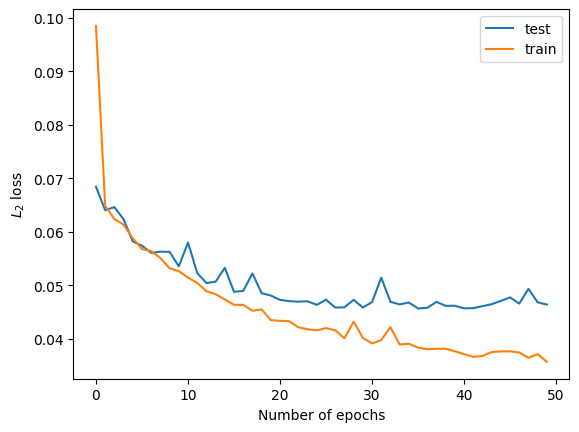

In [174]:
plt.plot(test_l2_ch, label='test')
plt.plot(train_l2_ch, label='train')
plt.ylabel(r'$L_2$ loss')
plt.xlabel('Number of epochs')
#plt.yscale('log')
plt.legend()

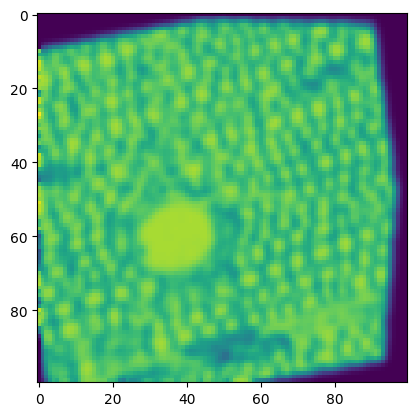

In [21]:
plt.imshow(y_full_train[0][::s, ::s])

5.0721405800906885


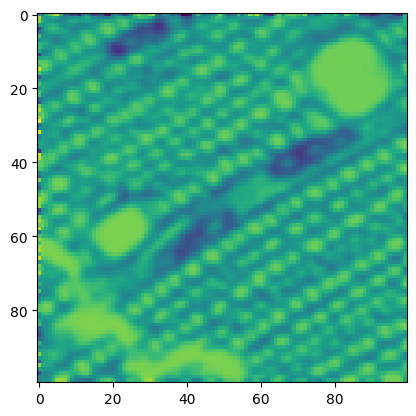

In [22]:
    s = 5
    func_test = x_full_train[50:51, ::s, ::s]
    func_test = torch.from_numpy(func_test)
    func_test = func_test.reshape(*func_test.shape, 1)
    func_test = func_test.cuda()
    func_true = y_full_train[50:51, ::s, ::s].reshape(int(500/s), int(500/s))
    model_res = model.forward(func_test)
    model_res = model_res.detach().cpu().numpy()
    model_res = model_res.reshape(int(500/s), int(500/s))
    print(np.max(np.max(np.absolute((model_res - func_true) / func_true))))
    plt.imshow(func_true)

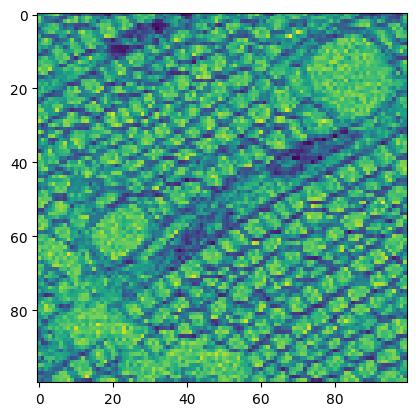

In [23]:
plt.imshow(x_full_train[50:51, ::s, ::s].reshape(100, 100))

In [24]:
model_res

array([[112.96112511, 112.05907954, 128.21493818, ...,  88.28082235,
         78.86409505,  94.65726656],
       [160.06942726, 145.58565173, 125.64713681, ..., 103.85171598,
        125.140317  , 132.77865525],
       [157.5557709 , 152.37829433, 154.06756082, ..., 143.52689979,
        141.27298535, 141.76984231],
       ...,
       [ 74.49908233,  94.49674352, 127.78888453, ..., 221.28399625,
        179.55989283, 147.10337633],
       [ 79.97497574, 101.71367117, 105.88788855, ..., 189.02803329,
        188.44542702,  96.24664407],
       [ 49.96583437,  54.42402093,  94.27769241, ..., 157.22924425,
        126.11776365,  80.82085804]])

In [25]:
func_true

array([[121.        , 100.        , 139.        , ...,  40.        ,
         49.        , 142.        ],
       [192.        , 131.41985654, 122.78711074, ...,  82.38069301,
        100.73193558, 139.19138455],
       [179.        , 137.86688881, 120.96038884, ..., 110.65328697,
        121.14182382, 138.79512229],
       ...,
       [ 61.        , 103.24681461, 105.06547245, ..., 154.16556224,
        147.8312785 , 146.46296583],
       [112.        , 107.09366084, 102.81109801, ..., 166.3463269 ,
        156.21876648, 137.83426406],
       [ 95.        , 118.52964338, 119.56877043, ..., 171.12558063,
        165.05921139, 136.28013022]])

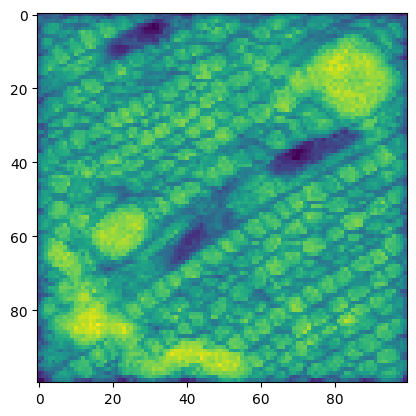

In [26]:
plt.imshow(model_res)